In [1]:
import pyam
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.transforms as mtransforms

from pathlib import Path

<IPython.core.display.Javascript object>

Step 1: Read in the compiled CDR dataset.

In [2]:
df = pyam.IamDataFrame(
    Path(
        '../data/101_data.xlsx'
    )
)

pyam - INFO: Running in a notebook, setting up a basic logging at level INFO
pyam.core - INFO: Reading file ../data/101_data.xlsx
pyam.core - INFO: Reading meta indicators


Step 2: Read in the filter sets for bioenergy (PE)

In [3]:
filter_set = pd.read_csv(
    Path(
        '../data/103_filter_set_bio.csv'
    ),
    index_col=[0,1]
)

In [4]:
filter_set_small = (
    filter_set
    .loc[df.meta.index.intersection(filter_set.index)]
)

In [5]:
df.set_meta(
    meta=False,
    name='bio_sustainable'
)

In [6]:
df.set_meta(
    meta=True,
    name='bio_sustainable',
    index=filter_set_small[filter_set_small['bio_sustainable']==True].index
)

In [7]:
df.set_meta(
    meta=filter_set_small['pe_bio_max'],
    name='pe_bio_max'
)

Step 3: For each world region, calculate the cumulative land and novel CDR over two time periods:
* 2020 to global net zero CO2
* Global net zero CO2 to 2100

In [8]:
netzero_year = df.meta.loc[:, 'Year of netzero CO2 emissions (Harm-Infilled) table']

In [9]:
netzero_year.fillna(2100, inplace=True)

In [10]:
novel_cdr = 'AR6 Reanalysis|OSCARv3.2|Carbon Removal|Non-Land'
conventional_cdr = 'AR6 Reanalysis|OSCARv3.2|Carbon Removal|Land'

In [11]:
for reg in df.region:
    if reg == 'World':
        continue
    for var in [novel_cdr, conventional_cdr]:
        if var == novel_cdr:
            meta_prefix = 'novel_cdr'
        else:
            meta_prefix = 'conventional_cdr'
        ts_data = (
            df
            .filter(
                region=reg,
                variable=var
            )
            .timeseries()
        )
        # The cumulative estimate to net zero
        df.set_meta(
            meta=ts_data.apply(
               lambda x: pyam.cumulative(
                   x,
                   first_year=2020,
                   last_year=netzero_year[x.name[0:2]]
               ),
               axis=1
            ),
            name=f'{meta_prefix}_{reg}_2020_netzero'
        )
        # The cumulative estimate to 2100
        df.set_meta(
            meta=ts_data.apply(
                lambda x: pyam.cumulative(
                    x,
                    first_year=netzero_year[x.name[0:2]],
                    last_year=2100
                ),
                axis=1
            ),
            name=f'{meta_prefix}_{reg}_netzero_2100'
        )

Step 4: Now, let us cut the bioenergy pe into a couple of bins.

In [12]:
region_to_assess = 'R5ASIA'

In [13]:
bins_for_pe = (
    pd
    .IntervalIndex
    .from_tuples(
        [
            (0, 100),
            (100, 300),
            (300, 500)
        ]
    )
)
bin_maps = dict(
    zip(
        bins_for_pe,
        [
            '0-100',
            '100-300',
            '300-500'
        ]
    )
)

In [14]:
df.meta.loc[:, 'category_pe'] = (
    pd.cut(
        df.meta.loc[:, 'pe_bio_max'],
        bins=bins_for_pe
    )
    .map(bin_maps)
)

Further format the data so that we can make quick plots to compare stuff.

In [15]:
cols_to_melt = [
    x for x in df.meta.columns if 'novel_cdr' in x or 'conventional_cdr' in x
]

In [16]:
melted_data = (
    pd.melt(
        frame=df.meta.reset_index(),
        id_vars=['model', 'scenario', 'Category', 'category_pe'],
        value_vars=cols_to_melt
    )
)

In [17]:
melted_data['variable'] = melted_data['variable'].apply(
    lambda x: x.replace('cdr', 'cdr_World') if 'R5' not in x else x
)

In [18]:
melted_data.loc[:, 'cdr_type'] = melted_data['variable'].apply(
    lambda x: x.split('_')[0] + '_' + x.split('_')[1]
)
melted_data.loc[:, 'region'] = melted_data['variable'].apply(
    lambda x: x.split('_')[2]
)
melted_data.loc[:, 'timeframe'] = melted_data['variable'].apply(
    lambda x: x.split('_')[3] + '_' + x.split('_')[4]
)

In [19]:
melted_data = melted_data[melted_data['region']!='World']

In [20]:
melted_data

,model,scenario,Category,category_pe,variable,value,cdr_type,region,timeframe
814,AIM/CGE 2.0,SSP1-26,C3,0-100,novel_cdr_R5ASIA_2020_netzero,24.417455,novel_cdr,R5ASIA,2020_netzero
815,AIM/CGE 2.0,SSP4-26,C3,100-300,novel_cdr_R5ASIA_2020_netzero,43.587851,novel_cdr,R5ASIA,2020_netzero
816,AIM/CGE 2.1,CD-LINKS_NPi2020_1000,C3,100-300,novel_cdr_R5ASIA_2020_netzero,22.878625,novel_cdr,R5ASIA,2020_netzero
817,AIM/CGE 2.1,CD-LINKS_NPi2020_400,C1,100-300,novel_cdr_R5ASIA_2020_netzero,5.437380,novel_cdr,R5ASIA,2020_netzero
818,AIM/CGE 2.1,CO_Bridge,C3,100-300,novel_cdr_R5ASIA_2020_netzero,82.251699,novel_cdr,R5ASIA,2020_netzero
...,...,...,...,...,...,...,...,...,...
8949,WITCH-GLOBIOM 4.4,CD-LINKS_INDC2030i_1600,C3,100-300,conventional_cdr_R5REF_netzero_2100,8.557753,conventional_cdr,R5REF,netzero_2100
8950,WITCH-GLOBIOM 4.4,CD-LINKS_NDC2030i_1000,C2,100-300,conventional_cdr_R5REF_netzero_2100,20.604691,conventional_cdr,R5REF,netzero_2100
8951,WITCH-GLOBIOM 4.4,CD-LINKS_NPi2020_1000,C1,100-300,conventional_cdr_R5REF_netzero_2100,14.679515,conventional_cdr,R5REF,netzero_2100
8952,WITCH-GLOBIOM 4.4,CD-LINKS_NPi2020_1600,C3,100-300,conventional_cdr_R5REF_netzero_2100,4.220197,conventional_cdr,R5REF,netzero_2100


# Figure 2

In [21]:
data_fig2 = melted_data[melted_data['timeframe']=='2020_netzero']

In [22]:
region_labels = {
    'R5ASIA':'Asia',
    'R5REF':'Reforming\nEconomies',
    'R5OECD90+EU':'OECD\nand EU',
    'R5MAF':'Middle East\nand Africa',
    'R5LAM':'Latin America\nand Caribbean'
}

In [23]:
data_fig2.loc[:, 'region'] = data_fig2['region'].map(region_labels)

/var/folders/nz/kr7bwztj0_d9xrfz1jd4zcdh0000gp/T/ipykernel_2735/3080856939.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_fig2.loc[:, 'region'] = data_fig2['region'].map(region_labels)


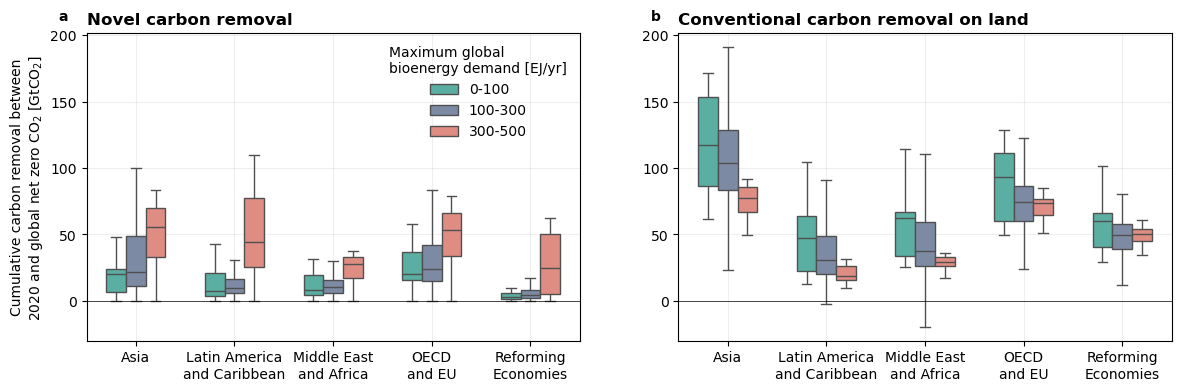

In [24]:
fig, ax = plt.subplot_mosaic(
    """
    ab
    """,
    sharey=True,
    figsize=(14,4)
)

for cdr_type in ['novel_cdr', 'conventional_cdr']:
    plot_data = data_fig2[data_fig2['cdr_type']==cdr_type]
    p = sns.boxplot(
        x='region',
        y='value',
        hue='category_pe',
        data=plot_data,
        ax=ax['a'] if cdr_type == 'novel_cdr' else ax['b'],
        showfliers=False,
        legend=True if cdr_type == 'novel_cdr' else False,
        width=0.6,
        palette=[
            '#4dbdab',
            '#7688ab',
            '#ee8172'
        ]
    )
    # Set the legend title
    if cdr_type=='novel_cdr':
        p.legend(title='Maximum global\nbioenergy demand [EJ/yr]', framealpha=0)
        p.set_title('Novel carbon removal', loc='left', weight='bold')
    else:
        p.set_title('Conventional carbon removal on land', loc='left', weight='bold')
    p.set_xlabel('')
    p.xaxis.set_tick_params(rotation=0)
    p.set_ylabel('Cumulative carbon removal between\n2020 and global net zero CO$_2$ [GtCO$_2$]')
    
ax['b'].yaxis.set_tick_params(labelbottom=True)
# Handle grids and annotations for subplots
for lab,a in ax.items():
    a.grid(alpha=0.2)
    trans = mtransforms.ScaledTranslation(-20/72, 7/72, fig.dpi_scale_trans)
    a.text(0.0, 1.0, lab, transform=a.transAxes + trans,
             va='bottom', weight='bold')
    a.axhline(0, color='black', linewidth=0.5)


In [25]:
fig.savefig(
    Path(
        'figures/fig2_final.png'
    ),
    bbox_inches='tight',
    dpi=400
)